In [4]:
import xarray as xr
from pathlib import Path
import numpy as np

import functions.eddy_feedback as ef
import functions.data_wrangling as data

In [ ]:
path = '/home/links/ct715/data_storage/isca/held-suarez'
nc_path = Path(path) / 'HS_T42_100y_60delh_epf.nc'

ds = xr.open_mfdataset(
    nc_path,
    parallel=True,
    chunks={'time': 360}
)

# discard first year, find seasonal means and rename vars
ds = ds.sel(time=slice('2000-12', '2099-11'))
ds = ds.resample(time='QS-DEC').mean('time')
# ds = ds[['ubar', 'divFy']]
ds

<xarray.Dataset>
Dimensions:  (time: 396, level: 40, lat: 64, lon: 128)
Coordinates:
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * level    (level) float64 987.5 962.5 937.5 912.5 ... 87.2 62.08 36.79 9.197
  * time     (time) object 2000-12-01 00:00:00 ... 2099-09-01 00:00:00
Data variables:
    u        (time, level, lat, lon) float32 dask.array<chunksize=(360, 40, 64, 128), meta=np.ndarray>
    v        (time, level, lat, lon) float32 dask.array<chunksize=(360, 40, 64, 128), meta=np.ndarray>
    t        (time, level, lat, lon) float32 dask.array<chunksize=(360, 40, 64, 128), meta=np.ndarray>
    ubar     (time, level, lat) float32 dask.array<chunksize=(360, 40, 64), meta=np.ndarray>
    epfy     (time, level, lat) float64 dask.array<chunksize=(360, 40, 64), meta=np.ndarray>
    epfz     (time, level, lat) float64 dask.array<chunksize=(360, 40, 64), meta=np.ndarray>
    divFy    (time, level, lat) float64 dask.array<chunksize=(360, 40, 64), meta=np.ndarray>
    divFz    (time, level, lat) float64 dask.array<chunksize=(360, 40, 64), meta=np.ndarray>
Attributes:
    filename:   /scratch/ct715/isca_work/experiment/HS_T42_100y_60delh/run/at...
    title:      FMS Model results
    grid_type:  regular
    grid_tile:  N/A

In [ ]:
seasonal_months = {
    'djf': 12,
    'mam': 3,
    'jja': 6,
    'son': 9
}
split_3way = {
    'set1': slice('2000-12', '2033-09'),
    'set2': slice('2033-12', '2066-09'),
    'set3': slice('2066-12', '2099-09')
}
hemispheres = {'SH': slice(-90, 0), 'NH': slice(0,90)}

subsets = {}
# Iterate through seasonal months, splits, and hemispheres
for season, months in seasonal_months.items():
    for split, split_range in split_3way.items():
        for hemisphere, lat_range in hemispheres.items():
            
            # Subset dataset for the season (handling multi-month selection)
            season_ds = ds.sel(time=ds.time.dt.month.isin(months))
            
            # Subset data for the time range split
            split_ds = season_ds.sel(time=split_range)
            
            # Subset data for the hemisphere
            hemis_ds = split_ds.sel(lat=lat_range)
            
            # Store the subset
            key = f'{season}_{hemisphere}_{split}'
            subsets[key] = hemis_ds
len(subsets)

24

In [ ]:
def calculate_efp_isca(ds, hemisphere='SH'):
    
    # calculate correlation and square it
    correlation = xr.corr(ds.divFy, ds.ubar, dim='time')
    corr = correlation**2
    
    # subset for EFP box, depending on hemis
    corr = corr.sel(level=slice(600., 200.))
    
    if hemisphere == 'NH':
        corr = corr.sel(lat=slice(25,75))
    elif hemisphere == 'SH':
        corr = corr.sel(lat=slice(-75,-25))
    else:
        print('Hemisphere not specified.')
        
    corr = corr.mean('level')
        
    weights = np.cos(np.deg2rad(corr.lat))
    eddy_feedback_param = corr.weighted(weights).mean('lat')
    
    return eddy_feedback_param.values.round(4)

test = subsets['djf_SH_set1']
calculate_efp_isca(test)

0.6383

In [ ]:
efp_HS = {}
for key, dataset in subsets.items():
    
    # distinguish between NH and SH datasets
    which_hemis = key.split('_')[1]
    
    # calculate EFP and save to a new dictionary
    efp = calculate_efp_isca(dataset, hemisphere=which_hemis)
    efp_HS[key] = efp

efp_HS

{'djf_SH_set1': 0.6383,
 'djf_NH_set1': 0.5901,
 'djf_SH_set2': 0.6262,
 'djf_NH_set2': 0.632,
 'djf_SH_set3': 0.6175,
 'djf_NH_set3': 0.6707,
 'mam_SH_set1': 0.6295,
 'mam_NH_set1': 0.5827,
 'mam_SH_set2': 0.6865,
 'mam_NH_set2': 0.6568,
 'mam_SH_set3': 0.6397,
 'mam_NH_set3': 0.6377,
 'jja_SH_set1': 0.5981,
 'jja_NH_set1': 0.6753,
 'jja_SH_set2': 0.6576,
 'jja_NH_set2': 0.6799,
 'jja_SH_set3': 0.6777,
 'jja_NH_set3': 0.6821,
 'son_SH_set1': 0.7354,
 'son_NH_set1': 0.6686,
 'son_SH_set2': 0.6628,
 'son_NH_set2': 0.6162,
 'son_SH_set3': 0.6277,
 'son_NH_set3': 0.6746}

# Seaborn boxplot

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt

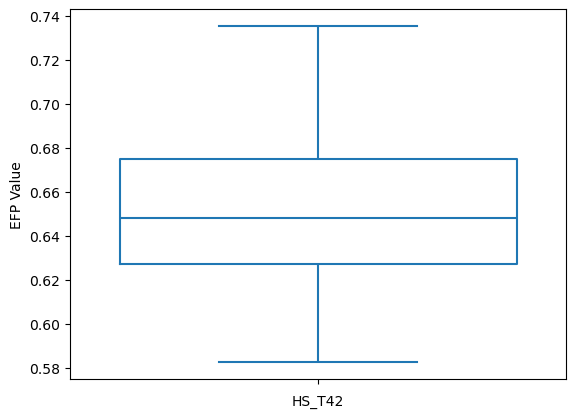

In [ ]:
sns.boxplot(efp_HS,
    fill=False,
).set(
    xlabel='HS_T42',
    ylabel='EFP Value'
)
plt.show()